In [1]:
import os 
import pandas as pd
import sys
import glob
import numpy as np 
import seaborn as sns

In [2]:
#load bed file and counts file for B97 
bed=pd.read_csv('/global/scratch/users/chandlersutherland/e16/B97/genome/Zm-B97-REFERENCE-NAM-1_all_gene.bed', sep='\t', lineterminator='\n')
count=pd.read_csv('/global/scratch/users/chandlersutherland/e16/B97/rna_tip/STAR/ERR3791683_ReadsPerGene.out.tab', sep='\t', names=['name', 'unstranded', 'stranded_1', 'stranded_2'])
count=count.drop(labels=['unstranded', 'stranded_2'], axis=1)
#filter out summary stats and keep the column with 
count=count[~count['name'].str.contains('N_')]

In [3]:
count

,name,stranded_1
4,Zm00018ab000010,5
5,Zm00018ab000020,110
6,Zm00018ab000030,0
7,Zm00018ab000040,0
8,Zm00018ab000060,0
...,...,...
40367,Zm00018ab460410,0
40368,Zm00018ab460420,0
40369,Zm00018ab460430,0
40370,Zm00018ab460450,0


In [4]:
bed['gene_length'] = 1 + bed['chromEnd'] - bed['chromStart']
bed

,Unnamed: 0,chrom,chromStart,chromEnd,name,strand,gene_length
0,1,chr1,41909,47507,Zm00018ab000010,+,5599
1,78,chr1,47035,54079,Zm00018ab000020,-,7045
2,188,chr1,112990,117509,Zm00018ab000030,-,4520
3,251,chr1,118481,118840,Zm00018ab000040,+,360
4,255,chr1,190664,192763,Zm00018ab000060,-,2100
...,...,...,...,...,...,...,...
40363,1117805,scaf_727,33094,34203,Zm00018ab460410,-,1110
40364,1117812,scaf_755,210,2489,Zm00018ab460420,-,2280
40365,1117824,scaf_755,2980,3661,Zm00018ab460430,-,682
40366,1117833,scaf_797,26383,26877,Zm00018ab460450,+,495


In [5]:
#Merge counts output and gene length by gene name 
merged=pd.merge(bed, count, on='name')
#Calculate RPK by dividing readcount by length of gene in kb
merged['RPK']=merged['stranded_1']*1000/merged['gene_length']
#Calculate per million scaling factor for the sample 
#Count up all the RPK values in a sample and divide this number by 1,000,000. This is your “per million” scaling factor.
scaling=merged['RPK'].sum()/1000000
merged['TPM']=merged['RPK']/scaling
merged['log2(TPM)']=np.log2(merged['TPM']+1)
merged

,Unnamed: 0,chrom,chromStart,chromEnd,name,strand,gene_length,stranded_1,RPK,TPM,log2(TPM)
0,1,chr1,41909,47507,Zm00018ab000010,+,5599,5,0.893017,1.705367,1.435825
1,78,chr1,47035,54079,Zm00018ab000020,-,7045,110,15.613911,29.817424,4.945674
2,188,chr1,112990,117509,Zm00018ab000030,-,4520,0,0.000000,0.000000,0.000000
3,251,chr1,118481,118840,Zm00018ab000040,+,360,0,0.000000,0.000000,0.000000
4,255,chr1,190664,192763,Zm00018ab000060,-,2100,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
40363,1117805,scaf_727,33094,34203,Zm00018ab460410,-,1110,0,0.000000,0.000000,0.000000
40364,1117812,scaf_755,210,2489,Zm00018ab460420,-,2280,0,0.000000,0.000000,0.000000
40365,1117824,scaf_755,2980,3661,Zm00018ab460430,-,682,0,0.000000,0.000000,0.000000
40366,1117833,scaf_797,26383,26877,Zm00018ab460450,+,495,0,0.000000,0.000000,0.000000


Ok, now repeat for all accessions and output to a single csv. This will require some finess to merge the correct tables together by accession and by rep. The final table will have: ecotype, rep, chrom, chromstart, chromend, name, strand, gene_length, count, tpm, log2(tpm). 

In [2]:
#get all bed files 
bed_files=glob.glob('/global/scratch/users/chandlersutherland/e16/*/genome/*all_gene.bed')

#get all counts files
count_files=glob.glob('/global/scratch/users/chandlersutherland/e16/*/rna_tip/STAR/*ReadsPerGene.out.tab')

In [3]:
#read in bed file and save accession and sample 
bed_df=pd.DataFrame()

for i in range(0, len(bed_files)):
    accession=bed_files[i].split('/')[6]
    bed=pd.read_csv(bed_files[i], sep='\t', lineterminator='\n')
    bed['accession']=accession
    bed['gene_length'] = 1 + bed['chromEnd'] - bed['chromStart']
    bed=bed.drop(['Unnamed: 0'], axis=1)
    
    bed_df=pd.concat([bed_df,bed])
    
bed_df

,chrom,chromStart,chromEnd,name,strand,accession,gene_length
0,chr1,41909,47507,Zm00018ab000010,+,B97,5599
1,chr1,47035,54079,Zm00018ab000020,-,B97,7045
2,chr1,112990,117509,Zm00018ab000030,-,B97,4520
3,chr1,118481,118840,Zm00018ab000040,+,B97,360
4,chr1,190664,192763,Zm00018ab000060,-,B97,2100
...,...,...,...,...,...,...,...
41054,scaf_1159,14194,18544,Zm00029ab462700,-,Ki3,4351
41055,scaf_1159,24174,24410,Zm00029ab462710,-,Ki3,237
41056,scaf_1159,24437,25012,Zm00029ab462720,-,Ki3,576
41057,scaf_1174,10087,10515,Zm00029ab462730,+,Ki3,429


In [4]:
#repeat with counts, with an extra column for biorep 
counts=pd.DataFrame()
for i in range(0, len(count_files)):
    accession=count_files[i].split('/')[6]
    sample=count_files[i].split('/')[-1].split('_')[0]
    
    #read in file 
    count=pd.read_csv(count_files[i], sep='\t', names=['name', 'unstranded', 'stranded_1', 'stranded_2'])
    count=count.drop(labels=['unstranded', 'stranded_2'], axis=1)
    
    #filter out summary stats and keep the column with 
    count=count[~count['name'].str.contains('N_')]
    
    #add accession and sample columns 
    count['accession']=accession
    count['sample']=sample 
    
    counts=pd.concat([counts,count])
    
counts

,name,stranded_1,accession,sample
4,Zm00018ab000010,3,B97,ERR3791685
5,Zm00018ab000020,130,B97,ERR3791685
6,Zm00018ab000030,0,B97,ERR3791685
7,Zm00018ab000040,0,B97,ERR3791685
8,Zm00018ab000060,0,B97,ERR3791685
...,...,...,...,...
41058,Zm00029ab462700,0,Ki3,ERR3791708
41059,Zm00029ab462710,0,Ki3,ERR3791708
41060,Zm00029ab462720,0,Ki3,ERR3791708
41061,Zm00029ab462730,0,Ki3,ERR3791708


In [5]:
#Merge counts output and gene length by gene name 
merged=pd.merge(bed_df, counts, on=['accession','name'])
#Calculate RPK by dividing readcount by length of gene in kb
merged['RPK']=merged['stranded_1']*1000/merged['gene_length']


In [6]:
#Calculate per million scaling factor for the sample 
#Count up all the RPK values in a sample and divide this number by 1,000,000. This is your “per million” scaling factor.
grouped=merged.groupby(['sample'])

tpm=pd.DataFrame()
for name, group in grouped: 
    scaling=group['RPK'].sum()/1000000
    group['TPM']=group['RPK']/scaling 
    tpm=pd.concat([tpm, group])

tpm

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,chrom,chromStart,chromEnd,name,strand,accession,gene_length,stranded_1,sample,RPK,TPM
808153,chr1,34617,40204,Zm00001eb000010,+,B73,5588,10,ERR3773816,1.789549,2.630175
808155,chr1,41214,46762,Zm00001eb000020,-,B73,5549,2,ERR3773816,0.360425,0.529732
808157,chr1,108554,114382,Zm00001eb000050,-,B73,5829,0,ERR3773816,0.000000,0.000000
808159,chr1,188559,189581,Zm00001eb000060,-,B73,1023,19,ERR3773816,18.572825,27.297255
808161,chr1,190192,198832,Zm00001eb000070,-,B73,8641,0,ERR3773816,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1786984,scaf_1508,8209,9582,Zm00042ab470600,+,Tzi8,1374,0,ERR3791734,0.000000,0.000000
1786986,scaf_1517,26315,28732,Zm00042ab470610,+,Tzi8,2418,0,ERR3791734,0.000000,0.000000
1786988,scaf_1546,1915,3135,Zm00042ab470620,-,Tzi8,1221,0,ERR3791734,0.000000,0.000000
1786990,scaf_1552,20729,22135,Zm00042ab470630,-,Tzi8,1407,0,ERR3791734,0.000000,0.000000


In [8]:
tpm['log2(TPM)']=np.log2(tpm['TPM']+1)
tpm=tpm[['accession', 'sample', 'name', 'chrom', 'chromStart', 'chromEnd', 'strand', 'gene_length', 'stranded_1', 'TPM', 'log2(TPM)']]
tpm

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,accession,sample,name,chrom,chromStart,chromEnd,strand,gene_length,stranded_1,TPM,log2(TPM)
808153,B73,ERR3773816,Zm00001eb000010,chr1,34617,40204,+,5588,10,2.630175,1.860039
808155,B73,ERR3773816,Zm00001eb000020,chr1,41214,46762,-,5549,2,0.529732,0.613279
808157,B73,ERR3773816,Zm00001eb000050,chr1,108554,114382,-,5829,0,0.000000,0.000000
808159,B73,ERR3773816,Zm00001eb000060,chr1,188559,189581,-,1023,19,27.297255,4.822590
808161,B73,ERR3773816,Zm00001eb000070,chr1,190192,198832,-,8641,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1786984,Tzi8,ERR3791734,Zm00042ab470600,scaf_1508,8209,9582,+,1374,0,0.000000,0.000000
1786986,Tzi8,ERR3791734,Zm00042ab470610,scaf_1517,26315,28732,+,2418,0,0.000000,0.000000
1786988,Tzi8,ERR3791734,Zm00042ab470620,scaf_1546,1915,3135,-,1221,0,0.000000,0.000000
1786990,Tzi8,ERR3791734,Zm00042ab470630,scaf_1552,20729,22135,-,1407,0,0.000000,0.000000


In [9]:
tpm.to_csv('/global/scratch/users/chandlersutherland/e16/cs_reports/rna_tip_tpm.tsv', sep='\t')

In [2]:
tpm=pd.read_csv('/global/scratch/users/chandlersutherland/e16/cs_reports/rna_tip_tpm.tsv', sep='\t')

In [3]:
tpm

,Unnamed: 0,accession,sample,name,chrom,chromStart,chromEnd,strand,gene_length,stranded_1,TPM,log2(TPM)
0,808153,B73,ERR3773816,Zm00001eb000010,chr1,34617,40204,+,5588,10,2.630175,1.860039
1,808155,B73,ERR3773816,Zm00001eb000020,chr1,41214,46762,-,5549,2,0.529732,0.613279
2,808157,B73,ERR3773816,Zm00001eb000050,chr1,108554,114382,-,5829,0,0.000000,0.000000
3,808159,B73,ERR3773816,Zm00001eb000060,chr1,188559,189581,-,1023,19,27.297255,4.822590
4,808161,B73,ERR3773816,Zm00001eb000070,chr1,190192,198832,-,8641,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2112299,1786984,Tzi8,ERR3791734,Zm00042ab470600,scaf_1508,8209,9582,+,1374,0,0.000000,0.000000
2112300,1786986,Tzi8,ERR3791734,Zm00042ab470610,scaf_1517,26315,28732,+,2418,0,0.000000,0.000000
2112301,1786988,Tzi8,ERR3791734,Zm00042ab470620,scaf_1546,1915,3135,-,1221,0,0.000000,0.000000
2112302,1786990,Tzi8,ERR3791734,Zm00042ab470630,scaf_1552,20729,22135,-,1407,0,0.000000,0.000000


In [4]:
#NLR only 
gene_table='/global/home/users/chandlersutherland/e16/Maize_NLRome_GeneTable.txt'
gene=pd.read_csv(gene_table,sep = '\t')
nlrs=gene['Gene'].str.split('_', expand=True).iloc[:,0].str.replace('ZM', 'Zm').str.replace('AB', 'ab').str.replace('EB', 'eb').unique()

nlr_tpm=tpm[tpm['name'].isin(nlrs)]
nlr_tpm


,Unnamed: 0,accession,sample,name,chrom,chromStart,chromEnd,strand,gene_length,stranded_1,TPM,log2(TPM)
992,810137,B73,ERR3773816,Zm00001eb010990,chr1,35063891,35068791,-,4901,1,0.299886,0.378385
1394,810941,B73,ERR3773816,Zm00001eb015450,chr1,52852085,52855107,-,3023,4,1.944746,1.558143
2181,812515,B73,ERR3773816,Zm00001eb024240,chr1,98884753,98889758,+,5006,1,0.293596,0.371387
2714,813581,B73,ERR3773816,Zm00001eb030390,chr1,167987200,167991827,+,4628,114,36.203663,5.217373
2950,814053,B73,ERR3773816,Zm00001eb033040,chr1,184428073,184439205,+,11133,23,3.036384,2.013063
...,...,...,...,...,...,...,...,...,...,...,...,...
2111785,1785956,Tzi8,ERR3791734,Zm00042ab463220,scaf_162,3747,20595,-,16849,1,0.100973,0.138780
2111787,1785960,Tzi8,ERR3791734,Zm00042ab463250,scaf_162,98676,108382,-,9707,63,11.041721,3.589970
2112210,1786806,Tzi8,ERR3791734,Zm00042ab469390,scaf_1032,23659,34832,+,11174,0,0.000000,0.000000
2112226,1786838,Tzi8,ERR3791734,Zm00042ab469660,scaf_1093,27330,29594,-,2265,10,7.511264,3.089373


In [13]:
gene

,Gene,Clade_0,Clade_1,Clade_2,Clade_3,Clade,Ecotype,Allele,File,HV
0,ZM00029AB319340_P001,Int3448_22,Int3448_22,NaN,NaN,Int3448_22,ki3,1,RAxML_tree_pbNB-ARC/Initial_Clades/Int3448_22.afa,0
1,ZM00023AB313710_P001,Int3448_22,Int3448_22,NaN,NaN,Int3448_22,cml247,1,RAxML_tree_pbNB-ARC/Initial_Clades/Int3448_22.afa,0
2,ZM00042AB469660_P001,Int3448_22,Int3448_22,NaN,NaN,Int3448_22,tzi8,1,RAxML_tree_pbNB-ARC/Initial_Clades/Int3448_22.afa,0
3,ZM00001EB304860_P001,Int3448_22,Int3448_22,NaN,NaN,Int3448_22,b73,1,RAxML_tree_pbNB-ARC/Initial_Clades/Int3448_22.afa,0
4,ZM00022AB310170_P001,Int3448_22,Int3448_22,NaN,NaN,Int3448_22,cml228,1,RAxML_tree_pbNB-ARC/Initial_Clades/Int3448_22.afa,0
...,...,...,...,...,...,...,...,...,...,...
3491,ZM00030AB305770_P001,Int6844_19,Int6844_19,NaN,NaN,Int6844_19,ki11,1,RAxML_tree_pbNB-ARC/Initial_Clades/Int6844_19.afa,0
3492,ZM00032AB317850_P001,Int6844_19,Int6844_19,NaN,NaN,Int6844_19,m37w,1,RAxML_tree_pbNB-ARC/Initial_Clades/Int6844_19.afa,0
3493,ZM00042AB318810_P001,Int6844_19,Int6844_19,NaN,NaN,Int6844_19,tzi8,1,RAxML_tree_pbNB-ARC/Initial_Clades/Int6844_19.afa,0
3494,ZM00039AB310760_P001,Int6844_19,Int6844_19,NaN,NaN,Int6844_19,oh43,1,RAxML_tree_pbNB-ARC/Initial_Clades/Int6844_19.afa,0


In [6]:
sub=gene.drop_duplicates(subset=['Gene'])
sub['name']=nlrs
sub=sub[['name', 'HV']]

hv_nlr=pd.merge(nlr_tpm, sub, on='name')
hv_nlr
#write out to df 
hv_nlr.to_csv('/global/scratch/users/chandlersutherland/e16/cs_reports/rna_tip_tpm_nlr_only.tsv', sep='\t')

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


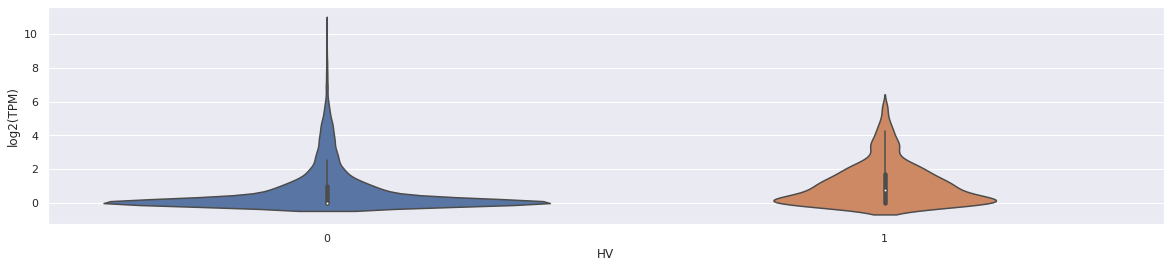

In [34]:
sns.set(rc={"figure.figsize":(20, 4)}) 
#sns.violinplot(data=hv_nlr, x="accession", y="log2(TPM)", hue="HV", split=True)
sns.violinplot(data=hv_nlr, x="HV", y="log2(TPM)")

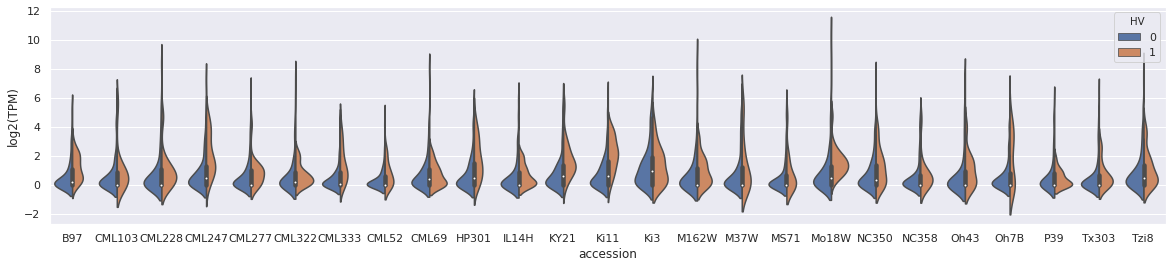

In [43]:
averaged=hv_nlr.groupby(['accession', 'sample', 'HV', 'name']).aggregate({'log2(TPM)' : 'mean'}).reset_index()
sns.violinplot(data=averaged, x="accession", y="log2(TPM)", hue="HV", split=True)

In [47]:
hv_nlr['accession'].unique()

25